In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import arch
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
matplotlib.rcParams["figure.figsize"] = (18, 5)

In [3]:
df = pd.read_csv("../Data/American Companies/AAPL 1980 2022.csv")
round(df.describe(), 2)

,Open,High,Low,Close,Adj Close,Volume
count,10591.00,10591.00,10591.00,10591.00,10591.00,1.059100e+04
mean,16.34,16.52,16.15,16.34,15.67,3.279409e+08
std,34.93,35.35,34.52,34.95,34.62,3.379428e+08
min,0.05,0.05,0.05,0.05,0.04,0.000000e+00
25%,0.29,0.29,0.28,0.29,0.24,1.215428e+08
50%,0.48,0.49,0.48,0.48,0.40,2.151072e+08
75%,16.01,16.19,15.80,15.98,13.84,4.069940e+08
max,182.63,182.94,179.12,182.01,180.96,7.421641e+09


In [4]:
open_prices = df.Open
dates = pd.to_datetime(df.Date, dayfirst= True)

test_size = -30

dates_train = np.array(dates[1:test_size])
dates_test = np.array(dates[test_size:])

returns = open_prices.pct_change()

returns_train = np.array(returns[1:test_size])
returns_test = np.array(returns[test_size:])

returns[1:].describe()

returns_train, returns_test

(array([-0.04782311, -0.07306276,  0.01970322, ..., -0.01914414,
         0.0008779 ,  0.03346833]),
 array([ 0.0125359 , -0.03952802, -0.04625713,  0.00021116, -0.03504817,
         0.02406829, -0.01360305,  0.01978343,  0.03242709,  0.02160193,
         0.02181647, -0.02029954, -0.01810509,  0.04015574, -0.01411591,
        -0.01351891,  0.00891104, -0.00762796, -0.02137414, -0.00585646,
        -0.0200291 ,  0.04816134, -0.01518116,  0.01240064, -0.00473707,
        -0.03318151,  0.00119558, -0.00014052,  0.00252916,  0.04765244]))

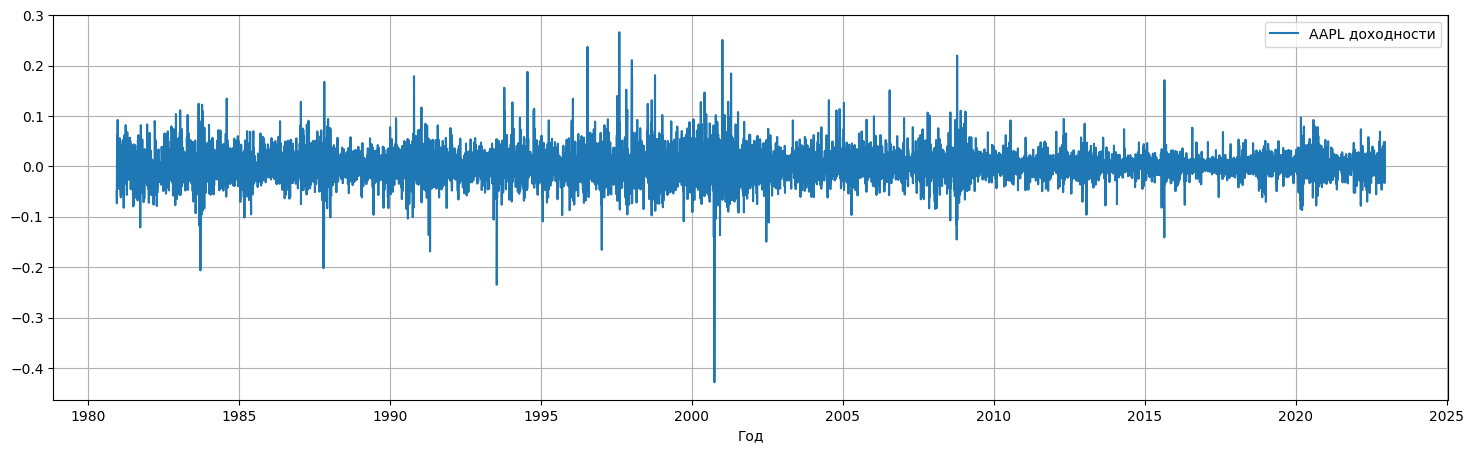

In [5]:
# plt.figure(figsize= (18, 5))
plt.plot(dates[1:], returns[1:], label= "AAPL доходности")
plt.grid(True)
plt.xlabel("Год")
plt.legend(loc= "best")
# plt.ylim(0, 0.05)
# plt.savefig("apple_returns.png", dpi= 180)
plt.show()

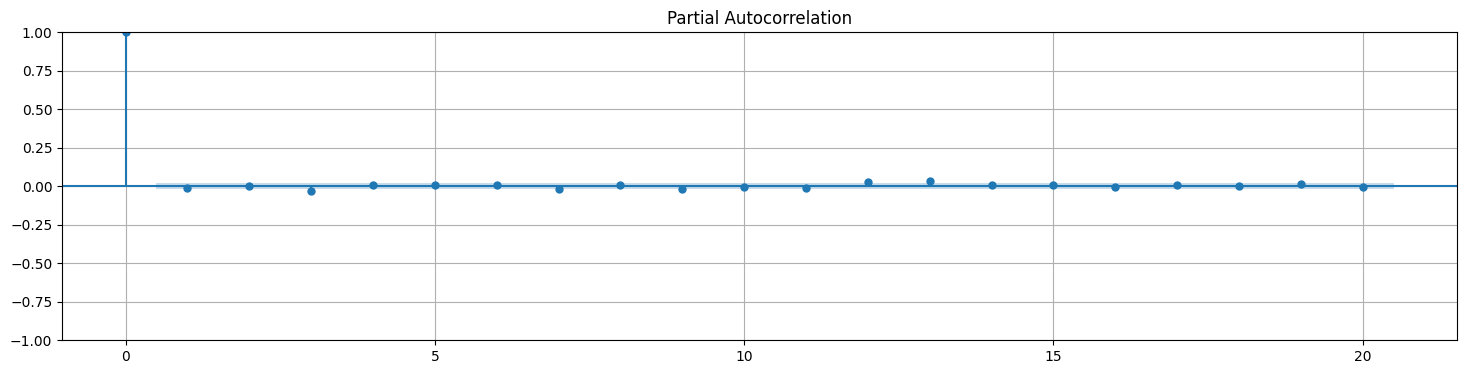

In [6]:
fig, axis = plt.subplots(1, 1, figsize= (18, 4))
plot_pacf(returns[1:], ax= axis, method= "ywm", lags= 20)
axis.grid(True)
# plt.savefig("garch_returns.png", dpi= 180)
plt.show()

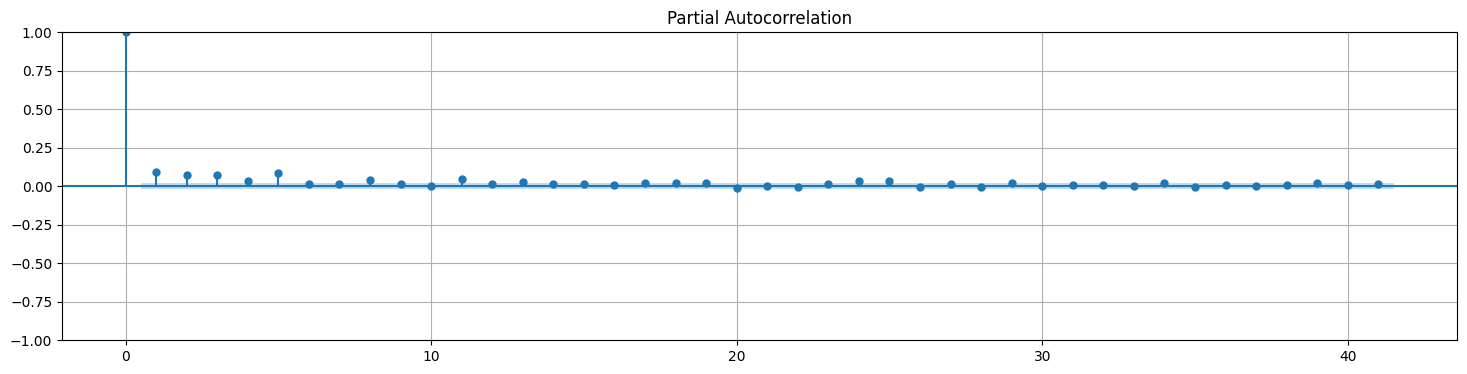

In [7]:
fig, axis = plt.subplots(1, 1, figsize= (18, 4))
plot_pacf(returns[1:] ** 2, ax= axis, method= "ywm")
axis.grid(True)
# plt.savefig("garch_returns_sqr.png", dpi= 180)
plt.show()

In [8]:
model = arch.arch_model(returns_train * 100, mean= "constant", vol= "FIGARCH", p= 1, q= 1, dist= "ged")
result = model.fit(disp= "off")
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Constant Mean - FIGARCH Model Results                           
==========================================================================================
Dep. Variable:                                  y   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                FIGARCH   Log-Likelihood:               -24358.4
Distribution:      Generalized Error Distribution   AIC:                           48728.7
Method:                        Maximum Likelihood   BIC:                           48772.3
                                                    No. Observations:                10560
Date:                            Wed, Mar 01 2023   Df Residuals:                    10559
Time:                                    19:57:33   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1051  2.690e-02      3.906  9.398e-05 [5.234e-02,  0.158]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3082  8.784e-02      3.509  4.498e-04 [  0.136,  0.480]
phi            0.2729  8.249e-02      3.308  9.398e-04 [  0.111,  0.435]
d              0.3289  2.609e-02     12.604  1.995e-36 [  0.278,  0.380]
beta           0.4920  8.531e-02      5.768  8.020e-09 [  0.325,  0.659]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.2046  2.668e-02     45.144      0.000 [  1.152,  1.257]
========================================================================

Covariance estimator: robust
"""

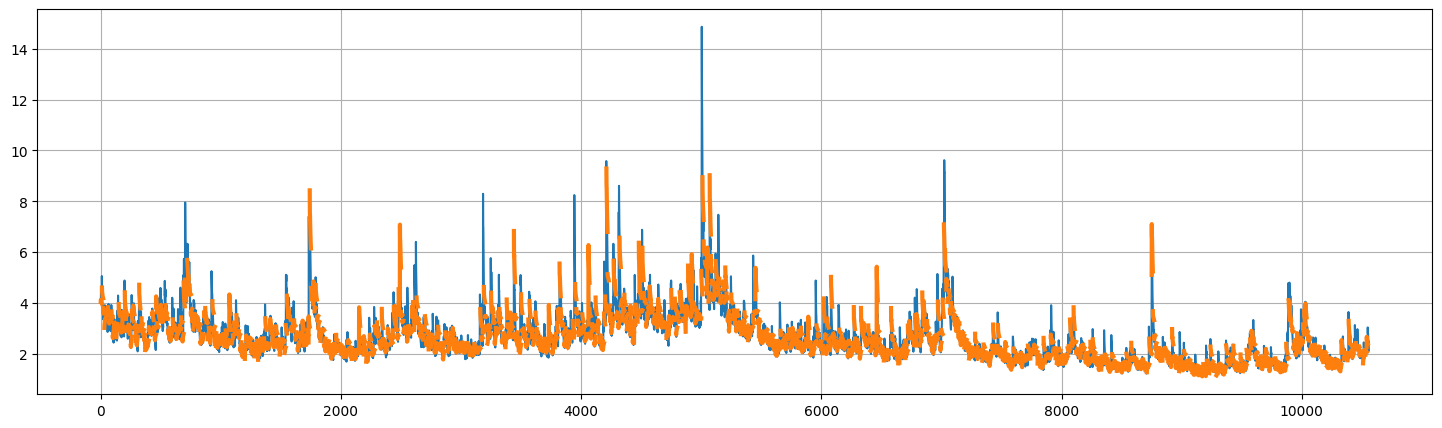

In [9]:
result.hedgehog_plot()
plt.grid(True)
plt.title("")
plt.show()

In [10]:
result.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 406.9305
P-value: 0.0000
Distributed: chi2(39)
WaldTestStatistic, id: 0x7f2b14bdba30

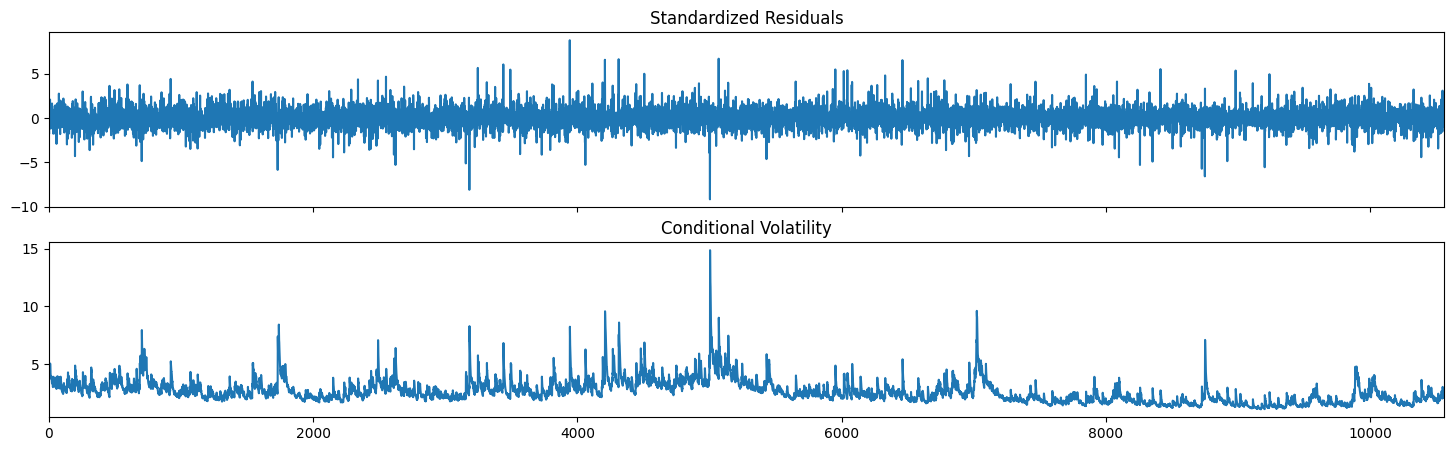

In [11]:
result.plot();
plt.show()

In [12]:
forecast = result.forecast(horizon= abs(test_size), reindex= True, simulations= 150, method= "bootstrap")

In [13]:
returns_train.shape

(10560,)

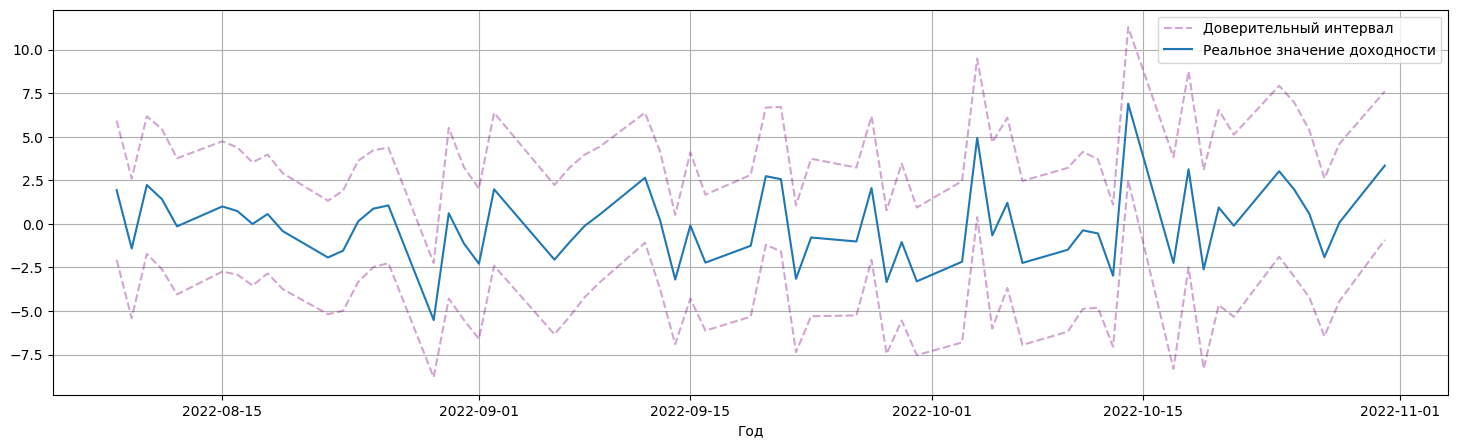

In [14]:
start = -60
# plt.title("Доходности цен открытия Apple с выхода на IPO по 2022 год (в %)")
plt.plot(np.array(dates_train)[start:], (np.array(returns_train) * 100 + 2 * result.conditional_volatility)[start:], color= "purple", alpha= 0.35, linestyle= "--", label= "Доверительный интервал")
plt.plot(np.array(dates_train)[start:], (np.array(returns_train) * 100 - 2 * result.conditional_volatility)[start:], color= "purple", alpha= 0.35, linestyle= "--")
plt.plot(np.array(dates_train)[start:], (np.array(returns_train) * 100)[start:], label= "Реальное значение доходности")
plt.grid(True)
plt.legend(loc= "best")
plt.xlabel("Год")
# plt.savefig("garch_returns_conditional_interval.png", dpi= 200)
plt.show()

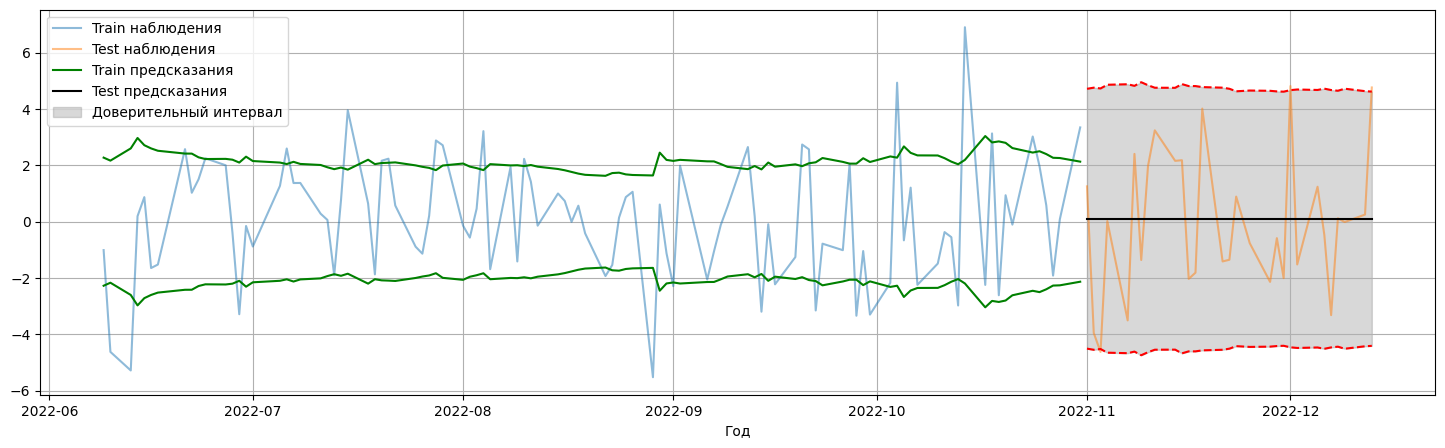

In [15]:
start = -100

# plt.title("Предсказание доходностей")
plt.grid(True)
plt.plot(np.array(dates_train)[start:], np.array((returns_train * 100))[start:], label= "Train наблюдения", alpha= 0.5)
plt.plot(dates_test, returns_test * 100, label= "Test наблюдения", alpha= 0.5)

plt.plot(np.array(dates_train)[start:], np.array((result.conditional_volatility[:]))[start:], label= "Train предсказания", color= "green")
plt.plot(np.array(dates_train)[start:], np.array((-result.conditional_volatility[:]))[start:], color= "green")

plt.plot(dates_test, (np.array(2 * forecast.variance[-1:] ** 0.5 + forecast.mean[-1:]).reshape(-1)), color= "red", linestyle= "--")
plt.plot(dates_test, (np.array(forecast.mean[-1:]).reshape(-1)), color= "black", label= "Test предсказания")
plt.plot(dates_test, (np.array(-2 * forecast.variance[-1:] ** 0.5 + forecast.mean[-1:]).reshape(-1)), color= "red", linestyle= "--")

plt.fill_between(dates_test,
                 (np.array(2 * forecast.variance[-1:] ** 0.5 + forecast.mean[-1:]).reshape(-1)),
                 (np.array(-2 * forecast.variance[-1:] ** 0.5 + forecast.mean[-1:]).reshape(-1)),
                 color= "gray", alpha= 0.3, label= "Доверительный интервал")

plt.xlabel("Год")
plt.legend(loc= "best")
# plt.savefig("figarch_predicton_long.png", dpi= 200)
plt.show()

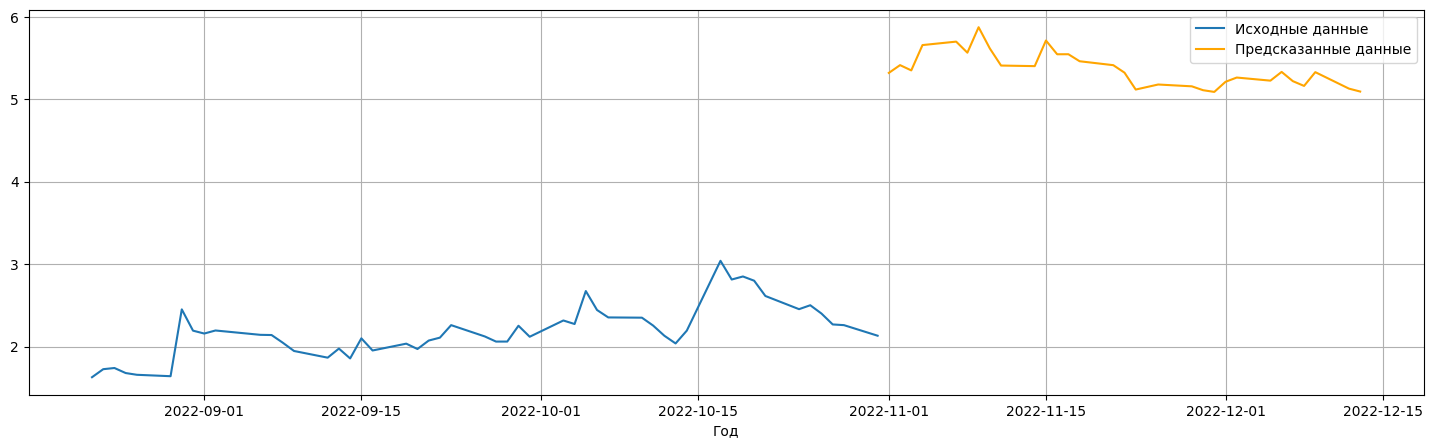

In [20]:
start = -50

# plt.title("Условная гетероскедастичность")
plt.plot(np.array(dates_train)[start:], np.array(result.conditional_volatility)[start:], label= "Исходные данные")
plt.plot(dates_test, np.array(forecast.residual_variance.dropna().squeeze()).reshape(-1), label= "Предсказанные данные", color= "orange")
plt.grid(True)
plt.xlabel("Год")
plt.legend(loc= "best")
# plt.savefig("figarch_cond_heter_forecast.png", dpi= 200)
plt.show()

In [17]:
# Построение графиков в соответствии со статьей: http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2019/03/02_GARCH.html